In [1]:
import numpy as np
import pandas as pd
import re,os,time, math
from shutil import copyfile
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
raw_df = pd.read_csv('/home/timhu/data/India_pov_pop_May17.csv')

## initial cleanup

In [3]:
raw_df.loc[:,raw_df.columns != 'CENSUS2011'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,568006.00,284001.89,163967.97,1.00,142002.25,284000.50,426001.75,568002.00
state_id,568006.00,16.92,8.53,1.00,9.00,19.00,23.00,35.00
secc_hh,568006.00,281.45,410.55,1.00,75.00,167.00,337.00,13333.00
secc_pop,568006.00,1393.75,1939.19,1.00,370.00,837.00,1702.00,61582.00
secc_pop_scaled,568006.00,1224.05,1707.63,0.75,325.35,734.95,1494.85,54504.45
secc_cons,567980.00,23432440.20,37969324.46,23203.48,5547085.28,12983540.42,27560439.46,1747434604.04
secc_pov_rate,567980.00,0.20,0.17,0.00,0.07,0.17,0.30,1.00
secc_pov_rate_tend,567980.00,0.14,0.13,0.00,0.03,0.10,0.20,1.00
secc_cons_per_hh,567980.00,81408.75,24569.78,156.74,63922.50,79304.40,94753.18,282054.66
secc_cons_per_cap,567980.00,16686.70,6538.26,27.56,12732.68,15425.28,19297.24,247666.09


In [4]:
# duplications in village_id
# raw_df[raw_df.duplicated(['village_id'], keep=False).values].head(10)

In [5]:
df = raw_df[['id','state_id','district_id', 'subdistrict_id', 'secc_pop','secc_pop_scaled','area','longitude','latitude']].copy()
# # remove all rows with duplicated value in village_id column
# df = df[~df.duplicated(['village_id'], keep=False).values]
# remove other rows with duplications in all columns, but keep one row
df = df.drop_duplicates(keep = 'first')
# # remove 'village_id' column
# df.drop('village_id', axis=1, inplace=True)
df.rename(columns={'id':'village_id'}, inplace=True)
df.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude
568001,567998,35,640,5924,69,62.30,nan,nan,nan
568002,567999,35,640,5924,201,181.00,nan,nan,nan
568003,568000,35,640,5924,145,129.90,nan,nan,nan
568004,568001,35,640,5924,173,154.80,nan,nan,nan
568005,568002,35,640,5924,62,57.50,nan,nan,nan


In [6]:
# remove rows with missing area/lat/long
df = df[df.area.notnull() & df.longitude.notnull() & df.latitude.notnull()].copy()
df.index = range(len(df))
df.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude
564550,567631,34,637,5915,6737,6049.45,4667679.81,79.79,10.92
564551,567632,34,637,5915,2260,2035.50,4514581.48,79.76,10.92
564552,567633,34,637,5915,3942,3527.60,5891136.02,79.74,10.93
564553,567634,34,637,5915,2521,2269.20,3121376.70,79.77,10.92
564554,567635,34,637,5915,3197,2873.10,4717539.22,79.79,10.91


## calculate density

In [295]:
# # adjusted the mistake from area conversion mistake.
# df['area'] = df.area * 1e4

In [9]:
# area in units of m2, calculate density as nums/km2
df['pop_density'] = df.secc_pop / (df.area / 10**6)
df['pop_density_log2'] = np.log2(df['pop_density'])
df.sort_values(by='pop_density', ascending=True).head()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2
119594,120007,9,151,792,1,1.00,194013437.59,80.28,28.60,0.01,-7.60
405552,408521,23,433,3492,1,1.00,122243595.08,75.77,24.71,0.01,-6.93
77960,78373,8,114,574,5,5.00,262882274.22,71.40,27.28,0.02,-5.72
10959,11187,2,25,116,1,1.00,51600612.59,78.34,32.08,0.02,-5.69
404671,407640,23,431,3484,1,1.00,40643229.81,81.11,23.57,0.02,-5.34


In [10]:
df.sort_values(by='pop_density', ascending=False).head()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2
206070,206483,10,222,1312,837,727.30,2392.20,86.05,25.43,349887.40,18.42
207404,207817,10,225,1345,354,311.00,1089.61,86.69,25.08,324886.28,18.31
338071,340972,21,377,2899,6540,5800.10,29983.56,86.98,21.49,218119.55,17.73
256792,259695,18,317,2103,3417,2938.00,15971.95,92.29,24.74,213937.58,17.71
206008,206421,10,222,1311,20200,17534.00,105617.48,85.98,25.48,191256.23,17.55


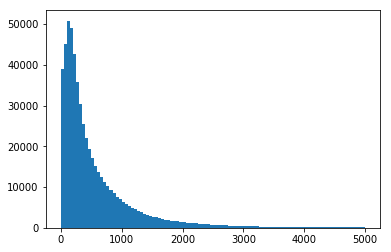

In [11]:
# distribution of density
n, bins, patches = plt.hist(df.pop_density.values, bins=100, range=(0,5000))

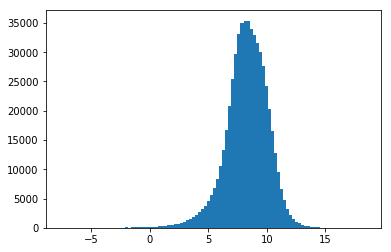

In [12]:
# distribution of log2 density
n, bins, patches = plt.hist(df.pop_density_log2.values, bins=100)

In [13]:
df.groupby('state_id')['pop_density', 'pop_density_log2'].agg([np.min, np.median, np.max, 'count'])

pop_density                          pop_density_log2               \
                amin  median      amax  count             amin median  amax   
state_id                                                                      
1               1.11  452.09  36291.87   6076             0.15   8.82 15.15   
2               0.02  235.60  34028.67  17597            -5.69   7.88 15.05   
3               0.25  346.98  22994.08  12152            -1.99   8.44 14.49   
4             993.52 2357.44   3786.44      5             9.96  11.20 11.89   
5               0.04  194.45  48207.64  14868            -4.74   7.60 15.56   
6               0.07  411.70  14474.98   6570            -3.92   8.69 13.82   
7              44.22  756.18 155428.06    106             5.47   9.56 17.25   
8               0.02  191.46  39520.76  41800            -5.72   7.58 15.27   
9               0.01  762.06  89057.66  92810            -7.60   9.57 16.44   
10              0.18 1144.06 349887.40  31786            -2.50  10.16 18.42   
11              0.05  246.39   4602.32    424            -4.40   7.94 12.17   
12              0.03   30.35   7237.49   4370            -4.95   4.92 12.82   
13              0.50   79.97  48948.16   1333            -1.01   6.32 15.58   
14              0.55  104.24  83776.15   2376            -0.87   6.70 16.35   
15              0.17   31.86   1058.19    463            -2.54   4.99 10.05   
16              4.89  323.78   6853.07    862             2.29   8.34 12.74   
17              0.21  135.29  21752.09   5598            -2.27   7.08 14.41   
18              0.37  479.97 213937.58  23091            -1.42   8.91 17.71   
19              0.24  758.68 117285.23  36435            -2.09   9.57 16.84   
20              0.28  340.47 129926.88  27391            -1.81   8.41 16.99   
21              0.10  306.22 218119.55  45963            -3.29   8.26 17.73   
22              0.29  221.32  92214.64  17932            -1.77   7.79 16.49   
23              0.01  185.36  50570.53  49079            -6.93   7.53 15.63   
24              0.03  230.36  22740.94  17813            -4.84   7.85 14.47   
26             56.56  357.07   2091.63     64             5.82   8.48 11.03   
27              0.05  196.77  60847.97  39822            -4.47   7.62 15.89   
28              0.05  222.63  31471.51  25633            -4.40   7.80 14.94   
29              0.07  205.45  20620.58  25869            -3.77   7.68 14.33   
30              0.11  205.55   4136.73    320            -3.13   7.68 12.01   
32              1.88  839.23   5949.54   1013             0.91   9.71 12.54   
33              0.17  377.02  37285.53  14845            -2.52   8.56 15.19   
34            259.73  938.18   3190.26     89             8.02   9.87 11.64   

                 
          count  
state_id         
1          6076  
2         17597  
3         12152  
4             5  
5         14868  
6          6570  
7           106  
8         41800  
9         92810  
10        31786  
11          424  
12         4370  
13         1333  
14         2376  
15          463  
16          862  
17         5598  
18        23091  
19        36435  
20        27391  
21        45963  
22        17932  
23        49079  
24        17813  
26           64  
27        39822  
28        25633  
29        25869  
30          320  
32         1013  
33        14845  
34           89

In [14]:
df.to_csv('/home/timhu/data/India_pov_pop_May17_density.csv')

## village area distribution 

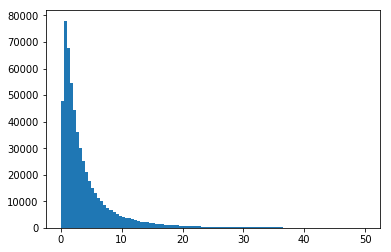

In [15]:
# distribution areas in km2
n, bins, patches = plt.hist(df.area.values / (10**6), bins=100, range=(0, 50))

In [16]:
print('median area (km2):', np.median(df.area.values) / (10**6))
print('mean area (km2):', np.mean(df.area.values) / (10**6))
print('95% percentile area (km2):', np.percentile(df.area.values, 95) / (10**6))
print('99% percentile area (km2):', np.percentile(df.area.values, 99) / (10**6))

median area (km2): 2.37460607655
mean area (km2): 4.35364674505
95% percentile area (km2): 14.3810221271
99% percentile area (km2): 29.2077693822


- the raw landsat inputs are 500x500 images with resolution 30m => covered area = 15km x 15km = 225 km2
- VGG cropped input are 224x224 images => covered area = (224 x 30 / 1000)^2 = 45.2 km2
- resize input 150x150 images => covered area = (150 x 30 / 1000)^2 = 20.25km2

## train/val/test partition without image overlap

In [17]:
# check the distinct numbers of states, districts, subdistricts
print('number of states:', len(df.state_id.unique()),
      'number of districts:', len(df.district_id.unique()),
      'number of subdistricts:', len(df.subdistrict_id.unique()))

# check whether each district_id is exclusively in one state_id, and also true for subdistrict_id and district_id
df_districts = df.groupby('district_id')['state_id'].agg([np.min, np.max])
print('districts that are in multiple states:', len(df_districts[(df_districts.amax - df_districts.amin) > 0]))
df_subdistricts = df.groupby('subdistrict_id')['district_id'].agg([np.min, np.max])
print('subdistricts that are in multiple districts:', len(df_subdistricts[(df_subdistricts.amax - df_subdistricts.amin) > 0]))

number of states: 32 number of districts: 619 number of subdistricts: 5724
districts that are in multiple states: 0
subdistricts that are in multiple districts: 32


In [18]:
# assign train/val/test split by stratification on subdistrict_id
# train 70% train, 20% Val, 10% test
np.random.seed(66)
all_sub_ids = df.subdistrict_id.unique()
val_test_ids = np.random.choice(all_sub_ids, int(0.3 * len(all_sub_ids)), replace=False)
test_ids = np.random.choice(val_test_ids, int(0.1 * len(all_sub_ids)), replace=False)
print('train/val/test subdistrict ids:')
print(len(all_sub_ids) - len(val_test_ids), len(val_test_ids), len(test_ids))

# assign the split as a new column 'partition'
df['partition'] = 'train'
df.loc[df.subdistrict_id.isin(val_test_ids),'partition'] = 'val'
df.loc[df.subdistrict_id.isin(test_ids),'partition'] = 'test'
print('train/val/test village ids:')
print(len(df[df.partition == 'train']), len(df[df.partition == 'val']), len(df[df.partition == 'test']))
# make sure the random seed works
np.random.rand(4)

train/val/test subdistrict ids:
4007 1717 572
train/val/test village ids:
393780 112416 58359


array([ 0.91146167,  0.27478055,  0.50450077,  0.0365537 ])

In [19]:
# the traning l8/s1 images covered area is 4.5 x 4.5 = 20.25km2
# define the the images are overlaped if the distance of their centers are shorter than 2.25
OVERLAP_DISTANCE = 2.25

# calculate the distance from 2 latitude and longitude coordinates
def distance(lat1, lon1, lat2, lon2):
    # radius of earch
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

In [ ]:
%%time
# remove training partition rows that have overlap with any val/test rows
# due to large computation, only consider subdistrict boundary overlap whithin one district
# it takes really long time!! ~4.5 hours
remove_ids = []
for did in df.district_id.unique():
    df_dis = df.loc[df.district_id == did]
    count = 0
    for i1, row_train in df_dis[df_dis.partition == 'train'].iterrows():
        for i2, row_vt in df_dis[df_dis.partition != 'train'].iterrows():
            lat1, lon1, lat2, lon2 =  row_train.latitude, row_train.longitude, row_vt.latitude, row_vt.longitude
            if distance(lat1, lon1, lat2, lon2) < OVERLAP_DISTANCE:
                remove_ids.append(row_train.village_id)
                count += 1
                break
    print('district %d removes %d/%d overlap village ids' % (did, count, len(df_dis)))

district 1 removes 0/338 overlap village ids
district 2 removes 0/459 overlap village ids
district 3 removes 0/23 overlap village ids
district 4 removes 0/72 overlap village ids
district 5 removes 11/170 overlap village ids
district 6 removes 6/373 overlap village ids
district 7 removes 1/488 overlap village ids
district 8 removes 19/459 overlap village ids
district 9 removes 0/117 overlap village ids
district 10 removes 0/11 overlap village ids
district 11 removes 0/112 overlap village ids


In [ ]:
print('total overlaping villages removed:', len(set(remove_ids)))
df = df[~df.village_id.isin(remove_ids)]

In [ ]:
df.to_csv('/home/timhu/data/India_pov_pop_May17_partiton.csv')

## add tif imge path


In [ ]:
df = pd.read_csv('/home/timhu/data/India_pov_pop_May17_partiton.csv', index_col=0)

In [ ]:
# initialize tif_path column
df['l8_vis_path'] = ''
df['s1_vis_path'] = ''
all_ids = df.village_id.values

# input all file names of tif images
with open('/home/timhu/data/output.txt') as f:
    filenames = f.readlines()
filenames = [x.strip() for x in filenames] 

# check if it is one-to-one map from village_id to tif filename (any other *_village_id.x.tif, x != 0)
l8_median_india_vis = [x for x in filenames if 'l8_median_india_vis' in x]
s1_median_india_vis = [x for x in filenames if 's1_median_india_vis' in x]
print('unique *_village_id.x.tif: ')
print(set([x[-6:] for x in l8_median_india_vis ]), set([x[-6:] for x in s1_median_india_vis ]))
# check if are unique for all rows in df
print('village_id unique:',len(set(df.village_id.values)) == len(df))
# number of villages, and number of tifs
print('all_ids', 'l8_median_india_vis', 's1_median_india_vis')
print(len(all_ids),len(l8_median_india_vis), len(s1_median_india_vis))

In [ ]:
# check the uniqueness of l8/s1 image tif id
vids = []
for i,f in enumerate(l8_median_india_vis):
    p = re.compile('(l8_median_india_vis_500x500_(\d+).0.tif)')
    filename, vid = p.findall(f)[0]
    vids.append(int(vid))
print(len(set(vids)), len(vids), max(vids))

In [ ]:
%%time
# attach tif file path to df table (takes ~10min)
df = df.sort_values(by='village_id')
l8_vis_path_array = df.l8_vis_path.values
s1_vis_path_array = df.s1_vis_path.values

for i,f in enumerate(l8_median_india_vis):   
    if i % 10000 == 0:
        print(i)
    p = re.compile('(l8_median_india_vis_500x500_(\d+).0.tif)')
    filename, vid = p.findall(f)[0]
    vid = int(vid)
    if vid in all_ids:
        path = 'l8_median_india_vis/' + filename
        l8_vis_path_array[np.where(all_ids==vid)[0][0]] = path
df.l8_vis_path = l8_vis_path_array

for i,f in enumerate(s1_median_india_vis):
    if i % 10000 == 0:
        print(i)
    p = re.compile('(s1_median_india_vis_500x500_(\d+).0.tif)')
    filename, vid = p.findall(f)[0]
    vid = int(vid)
    if vid in all_ids:
        path = 's1_median_india_vis/' + filename
        s1_vis_path_array[np.where(all_ids==vid)[0][0]] = path
df.s1_vis_path = s1_vis_path_array

In [ ]:
print(len(df), len(df[df.l8_vis_path != '']), len(df[df.s1_vis_path != '']))

In [ ]:
# remove rows with missing l8/s1 paths
df = df.loc[(df.l8_vis_path != '') & (df.s1_vis_path != '')]
print(len(df), len(df[df.l8_vis_path != '']), len(df[df.s1_vis_path != '']))

In [ ]:
df.to_csv('/home/timhu/data/all_paths_density_544k_May17.csv')

## create jpg path column in csv

In [ ]:
df['l8_vis_jpg'] = df.l8_vis_path.str.replace('500x500', '150x150')
df['l8_vis_jpg'] = df['l8_vis_jpg'].str.replace('tif', 'jpg')

df['s1_vis_jpg'] = df.s1_vis_path.str.replace('500x500', '450x450')
df['s1_vis_jpg'] = df['s1_vis_jpg'].str.replace('tif', 'jpg')
df.to_csv('/home/timhu/data/all_jpgpaths_density_544k_May17.csv')

## Data Cleaning / Extrme values removal (0.5% - 99.5% pop_density_log2)

In [ ]:
# df = pd.read_csv('/home/timhu/data/all_jpgpaths_density_544k_May14.csv', index_col=0)

In [ ]:
# remove 1% extrme data, filter out [0.5%, 99.5%] of pop_density_log2
ql = df.pop_density_log2.quantile(0.005)
qr = df.pop_density_log2.quantile(0.995)
print('remove 1 percent rows with pop_density_log2 < %.3f or > %.3f' % (ql, qr))

In [ ]:
df = df.loc[(df.pop_density_log2 > ql) & (df.pop_density_log2 < qr)]
df.index = range(len(df))

In [ ]:
df.tail()

In [ ]:
df.to_csv('/home/timhu/data/all_jpgpaths_clean_538k_May17.csv')

## Select single state (24)

In [ ]:
df_state24 = df[df.state_id == 24].copy()
df_state24.index = range(len(df_state24))
df_state24.tail()

In [ ]:
n, bins, patches = plt.hist(df_state24.pop_density_log2.values, bins=100)

In [ ]:
df_state24.to_csv('/home/timhu/data/state24_jpgpaths_clean_17k_May17.csv')

## Test

In [3]:
# df = pd.read_csv('/home/timhu/data/all_jpgpaths_clean_538k_May14.csv')

In [17]:
# df[df.l8_vis_path.str.startswith('l8_median_india_') != True]

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,partition,l8_vis_path,s1_vis_path,l8_vis_jpg,s1_vis_jpg
